In [2]:
%matplotlib inline
from misc.misc import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [3]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [4]:
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Visualising LSTM Networks Part 1

# Abstract

Long-Short Term Memory networks are state-of-the-art tools for long sequence modeling. However there is a problem with understanding what they have learned and investigating why they are making particular mistakes. Many articles and papers do it for convolutional neural networks, but for LSTM we don't have many tools to look inside and debug them. 

In this article we try to partially fill this gap. We visualize LSTM network activations from Australian sign language (Auslan) sign classifying model. We do this by learning denoising autoencoder on LSTM layer activations. We use dense autoencoders to project 100 dimensional vector of LSTM activations to 2 and 3 dimensions. Thanx to that we can explore activations space visually to some extent. We analyze this low dimensional space and try to find out how this dimensionality reduction can be helpful with finding relations between examples in dataset.

In [29]:
seed = 8
data_dir = './data'
model_weights_filename = './model_weights_final.hdf5'
autoenc2D_weights_file = './auto2D_model_weights.hdf5'
autoenc3D_weights_file = './auto3D_model_weights.hdf5'
train_size = 94*3*7
batch_size = 64
n_lstm = 100
epochs = 1000
noise = 0.1

# Auslan sign classifier

This article is a development of Miroslav Bartold's engineering thesis (Bartołd, 2017). Source of the dataset used in this thesis is (Kadous, 2002). 27 examples of each of 95 Auslan signs were captured from a native signer using glove with high-quality position trackers. The dataset and its description can be found at the following <a href="https://archive.ics.uci.edu/ml/datasets/Australian+Sign+Language+signs+(High+Quality)">link</a>.

Miroslav tested in his thesis some recurrent architectures of classifiers based on LSTM. Classifying accuracy was around 96%. For the people who are unfamiliar with the subject, there is a very good explanation of LSTM networks on [Christopher Olach's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In this research we focused on single architecture with one hidden layer of 100 LSTM cells. Last classifying (fully connected with softmax) layer have 94 neurons because there was a problem with some data files for one class. The longest sequence in dataset was 137 time steps, but we have dropped few longest examples, so the final length of longest sequence is 90 time steps. Every sign sequence in dataset have 22 sequences (11 for each hand). Every sequence was also filled at the beginning with zeros to reach length 90.

Network was implemented in Keras functional API, and is presented in Figure 1.

/home/djab/OPIUM/Blogposty/InzynierkaMirka/Blogpost_1/misc/misc.py:93: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  model = Model(input=input_layer, output=output_layer)


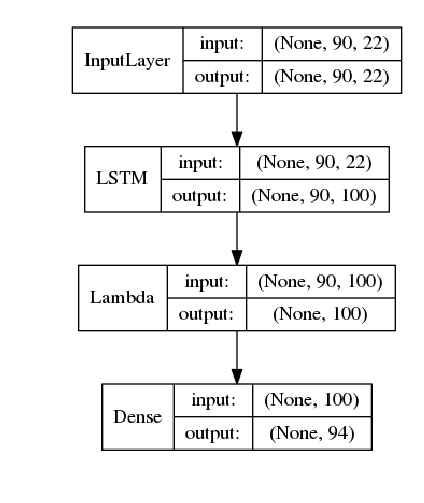

In [30]:
from keras.utils import plot_model
import matplotlib.image as mpimg

X_train, X_validation, X_test, Y_train, Y_validation, Y_test, le = load_prepare_data(data_dir, train_size, seed)
model, lstm_activations = prepare_model(100, 'accuracy', X_train, Y_train, (0.0, 0.0), (0.0, 0.0))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB')
img = mpimg.imread('model.png')
plt.figure(dpi=144)
plt.imshow(img)
plt.axis('off');

Because we were interested in full sequences of activations from LSTM layer, not only the last activations, we have made LSTM layer to return full sequence. Then we fed the full sequence to the next layer (called Lambda on Figure 1), and in there we took only the last activations and fed them to last classifying layer.

This allowed us to train whole model and make second model generating sequences of LSTM activations for all the input gestures. I encourage people, who are interested in technical details, to visit our [repository](), where you can find code which generates all models and visualizations used in this article.

In [31]:
# model, history = fit_model(model, model_weights_filename, X_train, Y_train, X_validation, Y_validation, seed, epochs=1000, patience=150, batch_size=64, verbosity=1)
model = load_model(model, model_weights_filename)
scores = model.evaluate(X_test, Y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1] * 100))

# First attempt to understand the internals of LSTM network

Inspired by the work [(Karpathy, 2015)](https://arxiv.org/abs/1506.02078) we wanted to localize some neurons responsible for sub-gestures easily recognizable by human (and shared between different signs), like making a fist or drawing a circle with hand. We failed to identify a single thing. We think this task was unsuccessful because of four main reasons:

 * The signal from position trackers is insufficient to fully reconstruct the motion of hands,
 * The representation of gesture is very different in the space of trackers and in reality,
 * We have only the videos of gestures from http://www.auslan.org.au, not the videos of dataset sign execution. We assume, that in general the gestures are the same, but we cannot observe mistakes in dataset. It is like comparing words written in regional dialect with their formal equivalents. For example in Warsaw we say "ziemniaki" to name potatoes whereas in Poznan people use word "pyry". Same meaning - different words.
 * 100 neurons and 94 signs is a very large space to cover with our four eyes.
 
Because of the failure of our first idea we focused only on visualization techniques in hope that they will help us to reveal some mysteries of LSTM layer and the dataset.

# Denoising Autoencoders

In order to visualize LSTM activation sequences for all gestures we will try to project 100D vectors representing activations at each time step to 2 or 3 dimensional vectors using denoising autoencoders. Autoencoders are composed from 5 fully connected layers, with 3rd layer as bottleneck with linear activation function. People unfamiliar with autoencoders can read about them [here](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2).

Linear activation function turned to be the best activation for purpose of legible plots. For all tested activation functions all example paths (term will be explained in next chapter) start near point (0,0). For non-antisymmetric functions (ReLU and sigmoid) all example paths were in upper right quarter of coordinate system. For antisymmetric functions, like tanh and linear, all paths were evenly distributed in all quarters around (0,0). However tanh function squashed some paths near -1 and 1, what the linear function did not do. People interested in visualizations for other activation function can find code to do this in [repository]().

Noise in autoencoders was added to input vectors and it was draw from normal distribution with standard deviation equal to 0.1.

On Figure 2 we present architecture of 2D autoencoder. 3D autoencoder was almost identical except it had 3 neurons in 3rd dense layer.

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


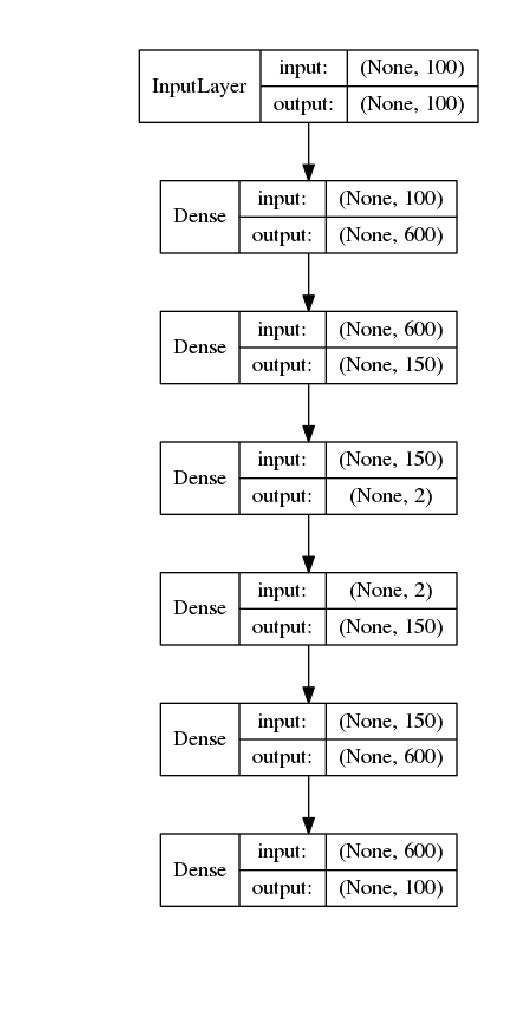

In [32]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

# def custom_activation(x):
#     return (K.tanh(x) * 20)

def custom_activation(x):
    return x

act = lstm_activations.predict(X_train)
labels = le.inverse_transform(np.argmax(Y_train, axis=1))
X_autoencoder, Y_autoencoder = prepare_autoencoder_input(act, noise, seed, min_=10, max_=65)

decoded2D, encoded2D = prepare_autoencoder(n_lstm, 2, dense_1=600, dense_2=150, activation=custom_activation)
# decoded2D, _ = fit_autoencoder(decoded2D, X_autoencoder, Y_autoencoder, autoenc2D_weights_file, seed, patience=5, verbosity=0)
decoded2D = load_model(decoded2D, autoenc2D_weights_file)
decoded3D, encoded3D = prepare_autoencoder(n_lstm, 3, dense_1=600, dense_2=150, activation=custom_activation)
# decoded3D, _ = fit_autoencoder(decoded3D, X_autoencoder, Y_autoencoder, autoenc3D_weights_file, seed, patience=5, verbosity=1)
decoded3D = load_model(decoded3D, autoenc3D_weights_file)

plot_model(decoded2D, to_file='2Dautoencoder.png', show_shapes=True, show_layer_names=False, rankdir='TB')
img = mpimg.imread('2Dautoencoder.png')
plt.figure(dpi=2*144)
plt.imshow(img)
plt.axis('off');

# Visualization

Autoencoders were trained on vectors of LSTM layer activations for all single time steps of each gesture realization. These vectors of activation were shuffled and some redundant activations were removed. By redundant activation we mean activation from the beginning and at the end of each gesture, where activation vector remained constant. Near the last step of some examples we present the name of the sign it represents.

So for each example in dataset we can make prediction with network ending with LSTM layer to get activations. By feeding list of these activations to encoder we obtain activations from 2D layer. We will call list of 2D vectors for each time step an example path in 2D (or 3D).

On the visualization each point represents each 2D activation from autoencoder for single time step and for one example. Color scale represent number of timestep (from 0 to 90) in each sign execution and black lines are connecting points from single example path. Each point before visualization was transformed by function ```lambda x: numpy.sign(x) * numpy.log1p(numpy.abs(x))```. This transformation allowed us to look more closely at the beginning of each path.

In figure 3 we present paths visualization for training set.

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


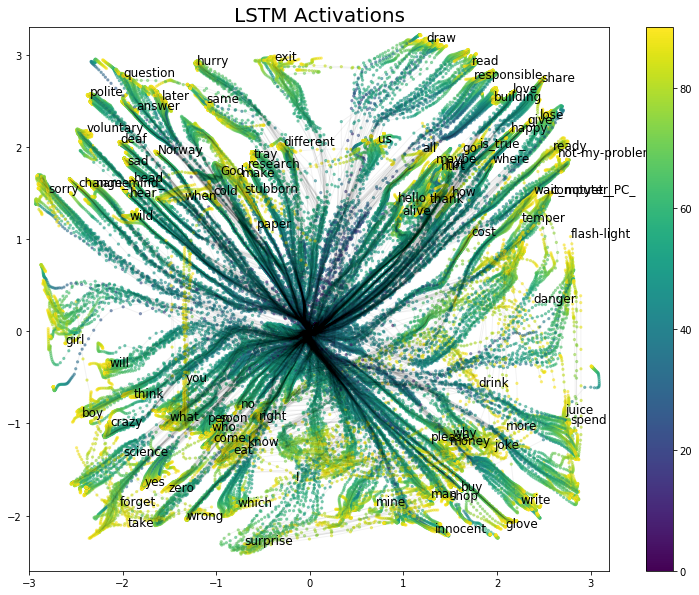

In [33]:
act = lstm_activations.predict(X_train)
labels = le.inverse_transform(np.argmax(Y_train, axis=1))
set_labels = sorted(set(labels))
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d.png', -3, 3.2, -2.6, 3.3, 
    figsize=(13,10), frac_labels=0.0, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

In figure 4 we present activations for last steps for each training example. This is the 2D projection of input to the classification layer.

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


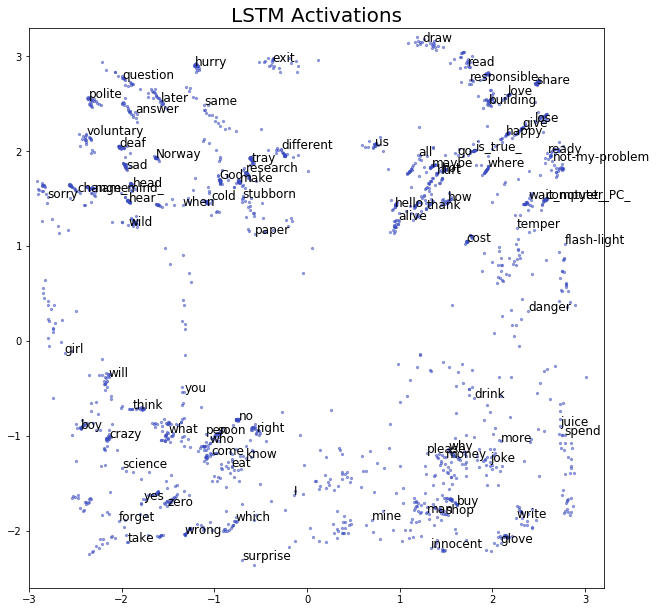

In [34]:
act = lstm_activations.predict(X_train)
labels = le.inverse_transform(np.argmax(Y_train, axis=1))
set_labels = sorted(set(labels))
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_last_activation.png', -3, 3.2, -2.6, 3.3, 
        figsize=(10.3,10.3), frac_labels=0.00, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, min_steps=89, max_steps=90, show=True, log=True,
        colormap=cm.coolwarm, scatter=True, colorbar_show=False)

It is quite surprising that all paths look very smooth and are localized in their parts of space because all activations for each time step and example where shuffled before training autoencoder. Spatial structure from figure 4 explains why our last classifying layer reaches good accuracy on such a small training set (near 2000 examples) and why adding a dense layer between LSTM and classifying layer doesn't help: the signs are well separated already.

For those who are interested in exploring this 2D space, we have rendered much bigger version of the figure 2 [here](https://image.ibb.co/fK867c/lstm2d_BIG.png).

In [35]:
# plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_BIG.png', -3, 3.2, -2.6, 3.3, 
#     figsize=(50,40), frac_labels=0.2, linewidth=1, pointsize=5, fontsize=10, linealpha=0.05, max_steps=90, show=True, log=True)

In figure 5 we present LSTM activations visualisation in 3D. For the sake of clarity we presented only points. For data analysis purpose we focus only on 2D visualizations in the latter part of this article.

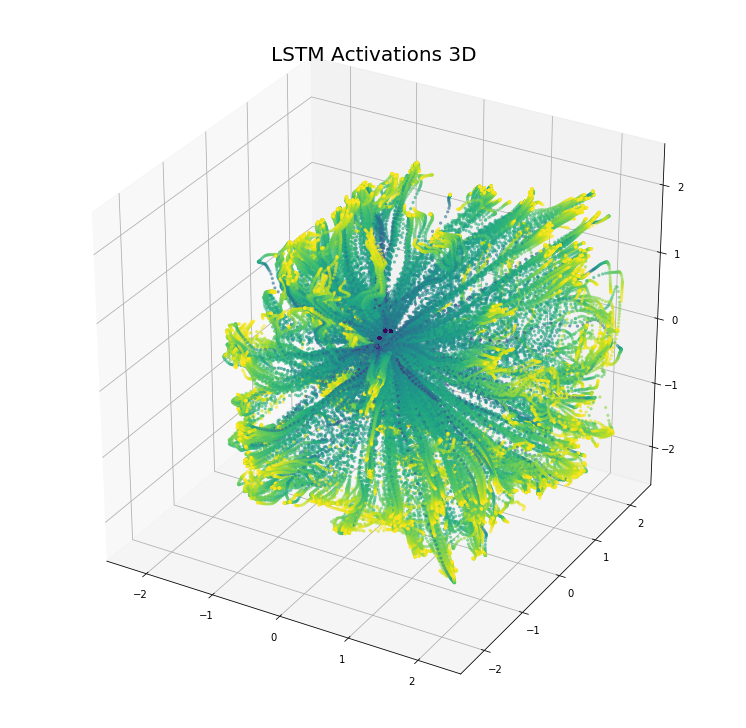

In [36]:
plot_3D(set_labels, encoded3D, act, labels, 'LSTM Activations 3D', 'lstm3d.png', x_l=-2.5,
            x_h=2.5, y_l=-2.5, y_h=2.5, figsize=(13, 13), frac_labels=0.5,
            linewidth=1, pointsize=5, fontsize=5, max_steps=90,
            show=True, log=True)

# Analysis

Visualizations look really nice, but is there something more meaningful in this? Does the closeness of some paths  mean, that these signs are more similar than the signs, which paths are far away from each other?

Let us take a look at this space when we take into account partition on right-handed and both-handed signs (we did not observe only left-handed signs). Partition of signs into this two categories were made based on statistics of variability on each hand tracker signals. More details in our [repository]().
 
For the sake of clarity we plot in figure 6 only paths without points. Right-handed signs are marked in cyan, and both-handed in magenta. We can see clearly, that both types of signs occupy other parts of the space and are not mixing with each other very often.

In [37]:
diff = X_train[:,:-1,:] - X_train[:,1:,:]
# plt.plot(np.abs(diff).mean(axis=2).mean(axis=0));
plt.show()
side = []
for i in range(diff.shape[0]):
    lh = np.abs(diff[i,:,:11])
    rh = np.abs(diff[i,:,11:])
    lh = np.sort(lh.flatten())[:950]
    rh = np.sort(rh.flatten())[:950]
    side.append(lh.mean() / rh.mean())
# plt.hist(side, bins=300);

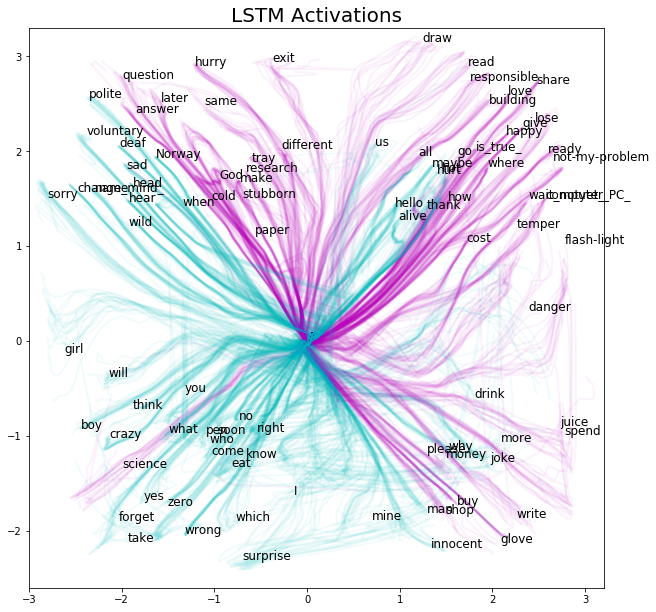

In [38]:
set_labels = sorted(set(labels))
# set_labels = ['drink', 'danger'] # dangerous tak naprawdę zamiast danger
one_hand = np.array(side) < 0.25
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_hands.png', -3, 3.2, -2.6, 3.3, 
        figsize=(10.3,10.3), frac_labels=0.0, linewidth=2, pointsize=3, fontsize=12, linealpha=0.05, 
        max_steps=90, show=True, log=True, hand=one_hand, colormap=cm.Greys, scatter=False, colorbar_show=False)

Now let us take a look at pair [drink](http://www.auslan.org.au/dictionary/words/drink-1.html)-[danger](http://www.auslan.org.au/dictionary/words/danger-1.html) (names of signs are linking to films on [Auslan signbank](http://www.auslan.org.au)). These are the two cyan gestures occupying the middle-right mostly magenta part of figure 6. In our data these two gestures are one-handed, but on the film from Auslan signbank [danger](http://www.auslan.org.au/dictionary/words/danger-1.html) is obviously two-handed. 

We think, that this is a problem with labeling or different dialect and the real gesture here is [dangerous](http://www.auslan.org.au/dictionary/words/dangerous-1.html) instead of [danger](http://www.auslan.org.au/dictionary/words/danger-1.html), which is one-handed and visually similar to [drink](http://www.auslan.org.au/dictionary/words/drink-1.html) (at least in his first part). We plot this two gestures on figure 7.

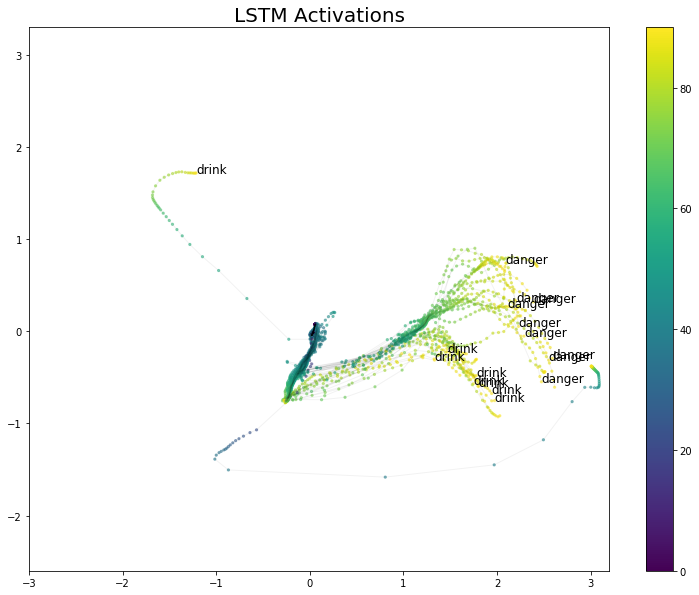

In [39]:
set_labels = ['drink', 'danger'] # dangerous tak naprawdę zamiast danger
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_drink_danger.png', -3, 3.2, -2.6, 3.3, 
    figsize=(13,10), frac_labels=0.4, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

[Who](http://www.auslan.org.au/dictionary/words/who-1.html) and [soon](http://www.auslan.org.au/dictionary/words/soon-1.html) signs seem very similar on figure 8. The glove have only one bend tracker and the finger bend measurements are not very exact (as written in <a href="https://archive.ics.uci.edu/ml/datasets/Australian+Sign+Language+signs+(High+Quality)">data description</a>). This is why this two gestures can look more similar on figure 8 than on the videos. But we can say to some extent, that these two gestures look also similar when looking at the videos.

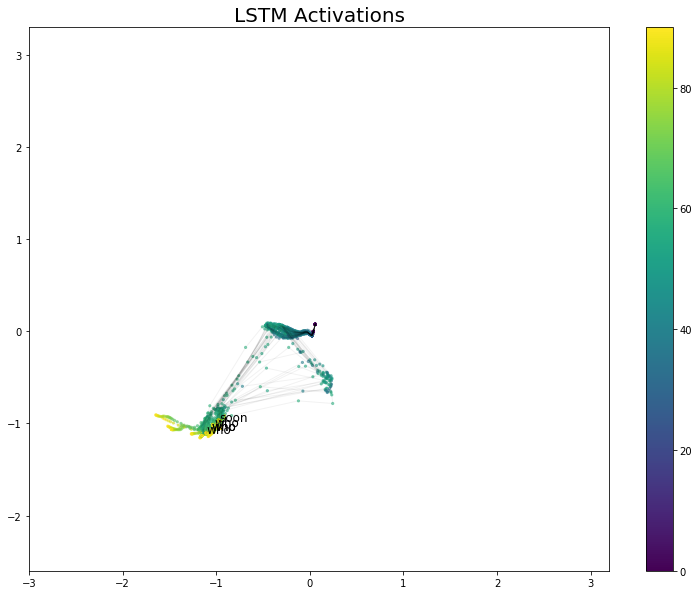

In [40]:
set_labels = ['who', 'soon']
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_who_soon.png', -3, 3.2, -2.6, 3.3, 
    figsize=(13,10), frac_labels=0.1, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

[Crazy](http://www.auslan.org.au/dictionary/words/crazy-1.html) and [think](http://www.auslan.org.au/dictionary/words/think-1.html) sign paths occupy the same space on figure 9. However [think](http://www.auslan.org.au/dictionary/words/think-1.html) seems to be a main part of slightly longer [crazy](http://www.auslan.org.au/dictionary/words/crazy-1.html) gesture. When we look at videos on Auslan signbank, we see that this relation is true and the [crazy](http://www.auslan.org.au/dictionary/words/crazy-1.html) sign looks like [think](http://www.auslan.org.au/dictionary/words/think-1.html) sign plus palm spread.

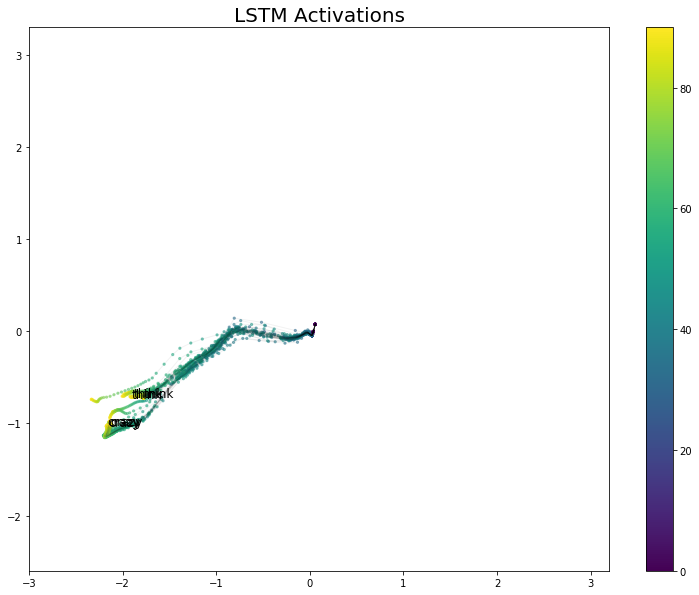

In [41]:
set_labels = ['crazy', 'think']
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_think_crazy.png', -3, 3.2, -2.6, 3.3, 
    figsize=(13,10), frac_labels=0.1, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

Although when we look at [you](http://www.auslan.org.au/dictionary/words/you-1.html) sign on figure 10 we can see that this sign goes perpendicular to other gestures like [crazy](http://www.auslan.org.au/dictionary/words/crazy-1.html), [think](http://www.auslan.org.au/dictionary/words/think-1.html), [sorry](http://www.auslan.org.au/dictionary/words/sorry-1.html) (and many other not shown here). But when we look on videos on signbank, we cant see anything similar between these signs and [you](http://www.auslan.org.au/dictionary/words/you-1.html). 

It can be caused by the same reasons like in [drink](http://www.auslan.org.au/dictionary/words/drink-1.html)-[danger](http://www.auslan.org.au/dictionary/words/danger-1.html)-[dangerous](http://www.auslan.org.au/dictionary/words/dangerous-1.html) case. It could also be some sort of compromise made by autoencoder during learning because not all spatial relations between examples from 100D space can be preserved in 2D space. It is hard to determine which reasoning is valid without reconstructing real gestures from the data and visualizing them as real hands.

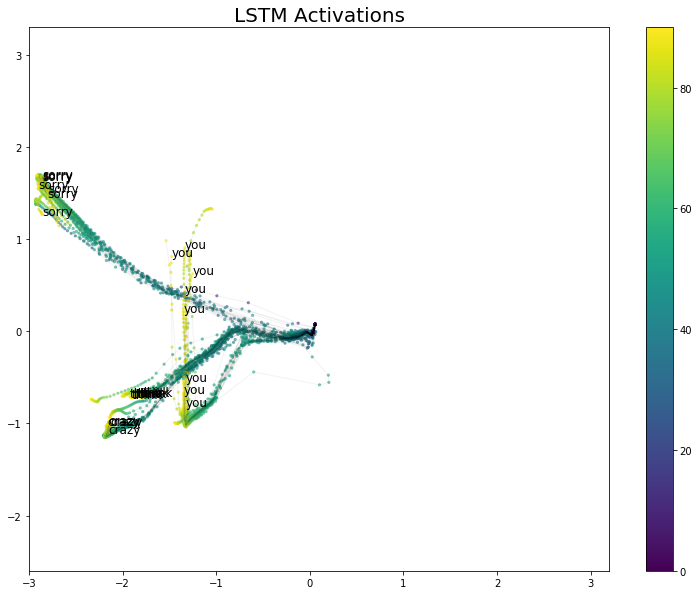

In [42]:
set_labels = ['sorry', 'crazy', 'you', 'think']
plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d_you.png', -3, 3.2, -2.6, 3.3, 
    figsize=(13,10), frac_labels=0.2, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

We also have to remember that each LSTM cell have its own memory and is fed by input sequence each step, so there are many more important latent variables than we fed into autoencoder.

Some of the close relations suggested by this visualisation turns out to be false. Some of them are changing between retraining of autoencoder or after retraining LSTM model. Some of them does not, and they are more likely to represent real similarities. For example [God](http://www.auslan.org.au/dictionary/words/God-1.html) and [science](http://www.auslan.org.au/dictionary/words/science-1.html) sometimes share similiar paths in 2D space and sometimes are far away from each other. Is that a coincidence? :)

# Mislabeled examples

At the end let us look at mislabeled examples. In figures 11, 12 and 13 we visualized mislabeled examples for training, validation and test set respectively. Blue label above mislabeled example is true class. Below there is a label chosen by model, marked in red.

For training examples there are only three mislabeled examples and two of them ([hurt](http://www.auslan.org.au/dictionary/words/hurt-1.html)-[all](http://www.auslan.org.au/dictionary/words/all-1.html) and [thank](http://www.auslan.org.au/dictionary/words/thank-1.html)-[hot](http://www.auslan.org.au/dictionary/words/hot-1.html)) are very close in 2D space. [Thank](http://www.auslan.org.au/dictionary/words/thank-1.html)-[hot](http://www.auslan.org.au/dictionary/words/hot-1.html) are also similar on the videos. [Hurt](http://www.auslan.org.au/dictionary/words/hurt-1.html)-[all](http://www.auslan.org.au/dictionary/words/all-1.html) are not.

As we can expect, in validation and test set there are more mislabeled examples, but the mistakes are made more often for gestures that are near in the projected space.

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


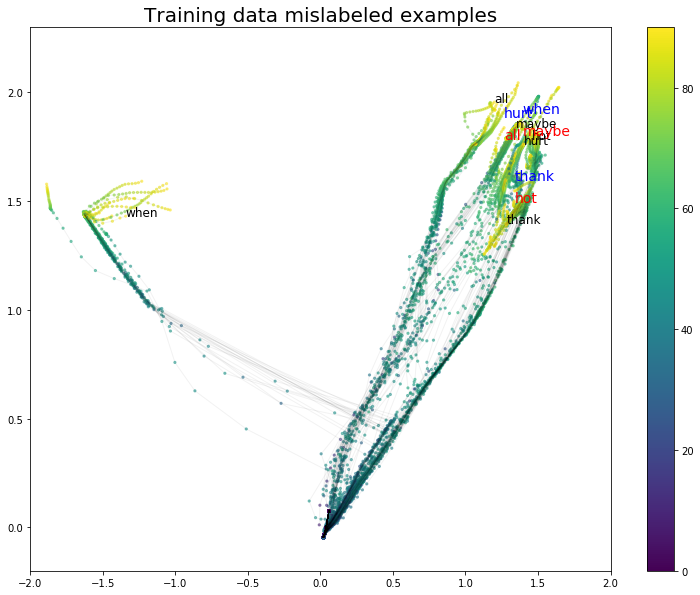

In [43]:
X = X_train
Y = Y_train
# X = X_validation
# Y = Y_validation
# X = X_test
# Y = Y_test

pred = le.inverse_transform(model.predict(X).argmax(axis=1))
true = le.inverse_transform(Y.argmax(axis=1))
mislabel = pred != true
pairs = np.array(list(zip(pred, true)))
set_labels = sorted(set(pairs[mislabel].flatten()))
act = lstm_activations.predict(X)
labels = le.inverse_transform(np.argmax(Y, axis=1))

# print(pairs[mislabel])

plot_2D_mislabeled(set_labels, encoded2D, act, labels, 'Training data mislabeled examples', 'lstm2d-mislabel_train.png', mislabel, pairs,-2, 2, -0.2, 2.3, 
                       figsize=(13,10), frac_labels=0.0, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


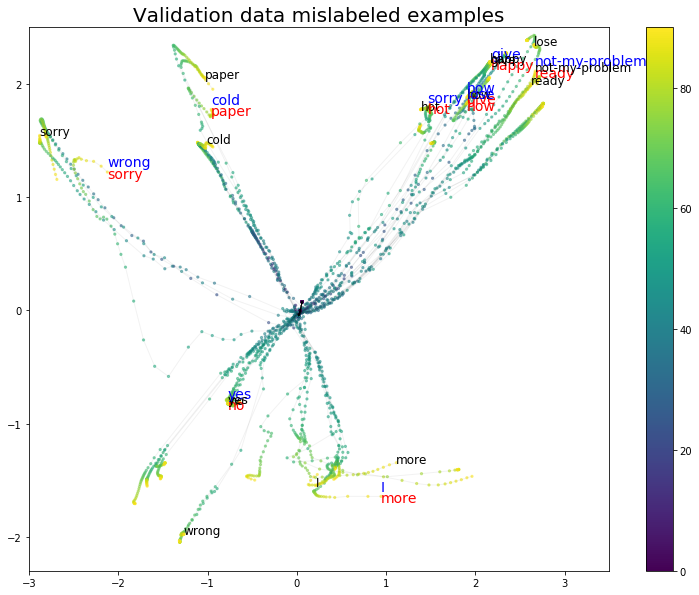

In [44]:
# X = X_train
# Y = Y_train
X = X_validation
Y = Y_validation
# X = X_test
# Y = Y_test

pred = le.inverse_transform(model.predict(X).argmax(axis=1))
true = le.inverse_transform(Y.argmax(axis=1))
mislabel = pred != true
pairs = np.array(list(zip(pred, true)))
set_labels = sorted(set(pairs[mislabel].flatten()))
act = lstm_activations.predict(X)
labels = le.inverse_transform(np.argmax(Y, axis=1))

# print(pairs[mislabel])

plot_2D_mislabeled(set_labels, encoded2D, act, labels, 'Validation data mislabeled examples', 'lstm2d-mislabel_valid.png', mislabel, pairs,-3, 3.5, -2.3, 2.5, 
                       figsize=(13,10), frac_labels=0.0, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


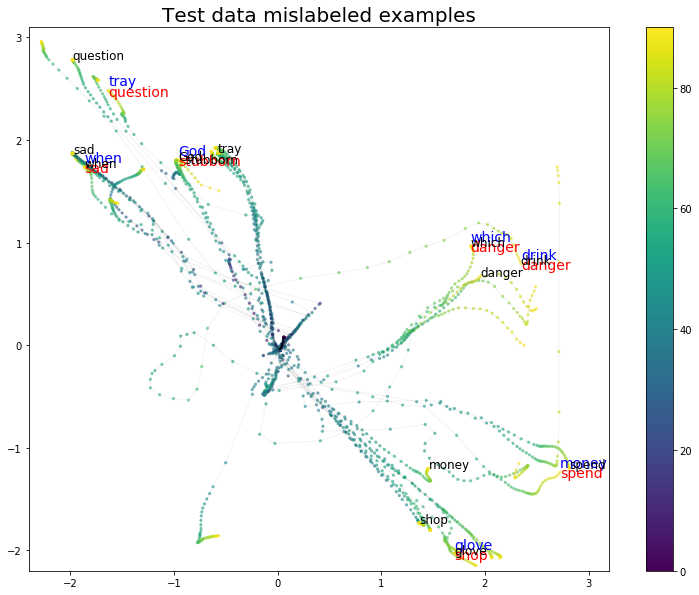

In [45]:
# X = X_train
# Y = Y_train
# X = X_validation
# Y = Y_validation
X = X_test
Y = Y_test

pred = le.inverse_transform(model.predict(X).argmax(axis=1))
true = le.inverse_transform(Y.argmax(axis=1))
mislabel = pred != true
pairs = np.array(list(zip(pred, true)))
set_labels = sorted(set(pairs[mislabel].flatten()))
act = lstm_activations.predict(X)
labels = le.inverse_transform(np.argmax(Y, axis=1))

# print(pairs[mislabel])

plot_2D_mislabeled(set_labels, encoded2D, act, labels, 'Test data mislabeled examples', 'lstm2d-mislabel_test.png', mislabel, pairs,-2.4, 3.2, -2.2, 3.1, 
                       figsize=(13,10), frac_labels=0.0, linewidth=1, pointsize=5, fontsize=12, linealpha=0.05, max_steps=90, show=True, log=True)

# Prediction visualisation

At the end we generated a [film](https://www.youtube.com/watch?v=95A1gbV3sqg) with a visualisation activations development during prediction.

In [46]:
act = lstm_activations.predict(X_train)
labels = le.inverse_transform(np.argmax(Y_train, axis=1))
set_labels = sorted(set(labels))

# for i in range(150):
#     plot_2D(set_labels, encoded2D, act, labels, 'LSTM Activations', 'lstm2d-{:03d}.png'.format(i), -3, 3.2, -2.6, 3.3, 
#             figsize=(18,15), frac_labels=0.0, linewidth=1, pointsize=5, fontsize=12, linealpha=0.03, max_steps=i, show=False, log=True)

/home/djab/OPIUM/Blogposty/InzynierkaMirka/mirek/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Conclusions

We managed to project 100D vector of activations to low-dimensional space. The projection looks interesting and seems to preserve many, but not all, relations between signs. These relations seem to be similar to relations we perceive while watching the gestures in real life, but it cannot be determined until we can't visualize the dataset in Auslan signbank way.

This tools can be used to some extent to peak into LSTM representation structure and can be a better tool to find relations between training examples than using raw input.

# References

 * Kadous, M. W., "Temporal Classification: Extending the Classification Paradigm to Multivariate Time Series", PhD Thesis (draft), School of Computer Science and Engineering, University of New South Wales, 2002
 * Karpathy, A., Johnson, J. and Fei-Fei, L., 2015. Visualizing and understanding recurrent networks. arXiv preprint arXiv:1506.02078.
 * Mirosław Bartołd, "Wykorzystanie sieci LSTM do rozpoznania znaków języka migowego”, Engineering Thesis, Polish-Japanese Institute of Information Technology, 2017

 